# Experiment on Gaussian Random Feature Model

This notebook provides small experiments in the paper "Inspecting Overfitting in Kernel Methods Through the Condition Number of Random Matrices". 


## 0. Import Packages

In [309]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import time

# Select one of the following
#np.random.seed(int(time.time()))
np.random.seed(0)

#graphic
sns.set(style="white")
sns.set_palette("dark")
#sns.pairplot(data, kind="scatter", hue = "Class")
plt.rcParams.update({'font.size': 30})
plt.rcParams['lines.linewidth'] = 4
plt.rc('legend',fontsize=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)

print("Packages imported.")

Packages imported.


## 1. Gaussian Random Feature Model

We assume that the input $x\sim\mathcal{N}(0,\Lambda^{1/2})$ is Gaussian where the covariance is a diagonal matrix $\Lambda$ with some decay.

In [320]:
N =  10 # training size
M = 100 # kernel rank

test_size = 1000 # test size

decay_factor = 2 # 2 is quadratic decay
noise_variance = 1

def polynomial_decay_matrix(decay_factor=decay_factor, size=M):
    # Generate diagonal entries following polynomial decay
    diagonal_entries = np.array([ (i+1)**(-decay_factor) for i in range(size)])

    # Create a diagonal matrix
    decay_matrix = np.diag(diagonal_entries)

    return decay_matrix

def generate_data(N=N, M=M, if_noise=False, noise_variance = 1,true_coefficients = np.random.normal(0, 1, size=M)):
# Generate a random Gaussian matrix with non-trivial covariance
    mean = np.zeros(M)  # Mean vector
    covariance_matrix = polynomial_decay_matrix(decay_factor=decay_factor, size=M)
    input = np.random.multivariate_normal(mean, covariance_matrix, size=N)
    output = np.dot(input, true_coefficients)
    if if_noise == True:
        output += np.random.normal(0, noise_variance, size=N)
    return input, output





In [321]:
# compute the MSE of linear regression
num_it = 20
N_list = np.arange(10,200,10)
theta = 10 # the overparameterization ratio
mse_list=[]
mse_upper_quartile = []
mse_lower_quartile = []
cond_list = []
cond_upper_quartile = []
cond_lower_quartile = []

for N in N_list:
    M = N * theta
    true_coefficients = np.random.normal(0, 1, size=M) # determine a new random true coefficient for each N,M
    X_test, y_test = generate_data(N=test_size, M=M, if_noise=False, noise_variance = noise_variance, true_coefficients=true_coefficients)
    mse_it = []
    cond_it = []
    for it in range(num_it):
        X_train, y_train = generate_data(N=N, M=M, if_noise=True, noise_variance = noise_variance,true_coefficients=true_coefficients)
        # Compute condition number
        covariance = X_train @ X_train.T
        eigenvalues = np.linalg.eigvalsh (covariance)
        condition_num = np.max(eigenvalues)/np.min(eigenvalues)
        cond_it.append(condition_num)
        # Initialize and fit the linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        mse_it.append(mse)
    mse_list.append(np.percentile(mse_it, 50))
    mse_upper_quartile.append(np.percentile(mse_it, 75))
    mse_lower_quartile.append(np.percentile(mse_it, 25))
    cond_list.append(np.percentile(cond_it, 50))
    cond_upper_quartile.append(np.percentile(cond_it, 75))
    cond_lower_quartile.append(np.percentile(cond_it, 25))


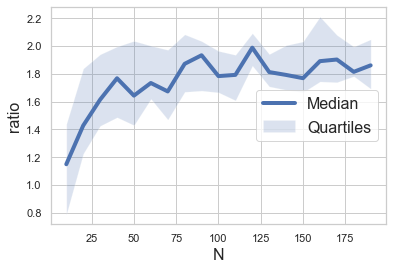

In [312]:
# plot the estimation of condition number
cond_list_estimation = np.array([(N+1)**(decay_factor) for N in N_list])
sns.set(style="whitegrid")
sns.lineplot(x=N_list, y=np.array(cond_list)/cond_list_estimation, label= "Median", linewidth = 4)
plt.fill_between(x=N_list, y1=np.array(cond_lower_quartile)/cond_list_estimation, y2=np.array(cond_upper_quartile)/cond_list_estimation, alpha=0.2, label='Quartiles')
#plt.title("ratio between empirical condition number and its asymtpotic estimate")
plt.xlabel("N", fontsize = 16)
#plt.yscale("log")
plt.ylabel("ratio", fontsize = 16)
plt.legend(loc = 'center right', fontsize = 16)
# Show the plot
plt.savefig('cond_num_poly.pdf', bbox_inches="tight")
plt.show()

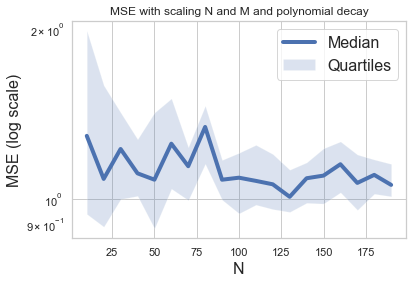

In [322]:
# plot the learning curve
sns.set(style="whitegrid")
sns.lineplot(x=N_list, y=mse_list, label= "Median",linewidth = 4)
plt.fill_between(x=N_list, y1=mse_lower_quartile, y2=mse_upper_quartile, alpha=0.2, label='Quartiles')
plt.title("MSE with scaling N and M and polynomial decay")
plt.xlabel("N", fontsize = 16)
plt.yscale("log")
plt.ylabel("MSE (log scale)", fontsize = 16)
plt.legend(fontsize = 16)
# Show the plot
plt.savefig('learning_curve_poly.pdf', bbox_inches="tight")
plt.show()

We see that the polynomial decay would yield a tempered overfitting.

In [314]:
N =  10 # training size
M = 100 # kernel rank

test_size = 1000 # test size

decay_factor = 1.1
noise_variance = 1

def exponential_decay_matrix(decay_factor=decay_factor, size=M):
    # Generate diagonal entries following polynomial decay
    diagonal_entries = np.array([ decay_factor**(-(i+1)) for i in range(size)])

    # Create a diagonal matrix
    decay_matrix = np.diag(diagonal_entries)

    return decay_matrix

def generate_data(N = N, M = M, if_noise = False, noise_variance = 1, true_coefficients = true_coefficients):
# Generate a random Gaussian matrix with non-trivial covariance
    mean = np.zeros(M)  # Mean vector
    covariance_matrix = exponential_decay_matrix(decay_factor=decay_factor, size=M)
    input = np.random.multivariate_normal(mean, covariance_matrix, size=N)
    output = np.dot(input, true_coefficients)
    if if_noise == True:
        output += np.random.normal(0, noise_variance, size=N)
    return input, output

num_it = 20
N_list = np.arange(10,200,10)
theta = 10 # the overparameterization ratio
mse_list=[]
mse_upper_quartile = []
mse_lower_quartile = []
cond_list = []
cond_upper_quartile = []
cond_lower_quartile = []

for N in N_list:
    M = N * theta
    true_coefficients = np.random.normal(0, 1, size=M) # determine a new random true coefficient for each N,M
    X_test, y_test = generate_data(N=test_size, M=M, if_noise=False, noise_variance = noise_variance, true_coefficients=true_coefficients)
    mse_it = []
    cond_it = []
    for it in range(num_it):
        X_train, y_train = generate_data(N=N, M=M, if_noise=True, noise_variance = noise_variance,true_coefficients=true_coefficients)
        # Compute condition number
        covariance = X_train @ X_train.T
        eigenvalues = np.linalg.eigvalsh (covariance)
        condition_num = np.max(eigenvalues)/np.min(eigenvalues)
        cond_it.append(condition_num)
        # Initialize and fit the linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        mse_it.append(mse)
    mse_list.append(np.percentile(mse_it, 50))
    mse_upper_quartile.append(np.percentile(mse_it, 75))
    mse_lower_quartile.append(np.percentile(mse_it, 25))
    cond_list.append(np.percentile(cond_it, 50))
    cond_upper_quartile.append(np.percentile(cond_it, 75))
    cond_lower_quartile.append(np.percentile(cond_it, 25))




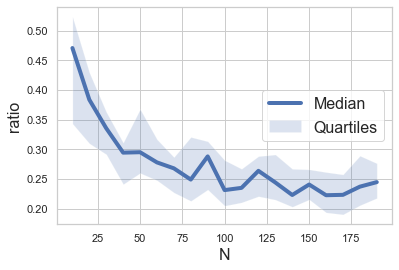

In [316]:
# plot the estimation of condition number
cond_list_estimation = np.array([N * decay_factor**(N) for N in N_list])
sns.set(style="whitegrid")
sns.lineplot(x=N_list, y=np.array(cond_list)/cond_list_estimation, label= "Median", linewidth = 4)
plt.fill_between(x=N_list, y1=np.array(cond_lower_quartile)/cond_list_estimation, y2=np.array(cond_upper_quartile)/cond_list_estimation, alpha=0.2, label='Quartiles')
#plt.title("ratio between empirical condition number and its asymtpotic estimate")
plt.xlabel("N", fontsize = 16)
#plt.yscale("log")
plt.ylabel("ratio", fontsize = 16)
plt.legend(loc = 'center right', fontsize = 16)
# Show the plot
plt.savefig('cond_num_exp.pdf', bbox_inches="tight")
plt.show()

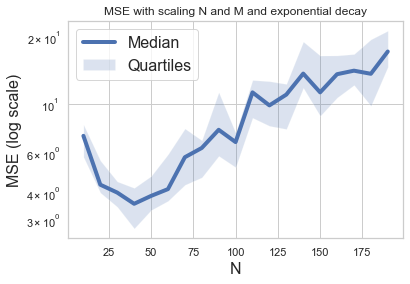

In [317]:
# plot learning curve
sns.set(style="whitegrid")

sns.lineplot(x=N_list, y=mse_list, label= "Median", linewidth = 4)
plt.fill_between(x=N_list, y1=mse_lower_quartile, y2=mse_upper_quartile, alpha=0.2, label='Quartiles')
plt.title("MSE with scaling N and M and exponential decay")
plt.xlabel("N", fontsize = 16)
plt.yscale("log")
plt.ylabel("MSE (log scale)", fontsize = 16)
plt.legend(fontsize = 16)
# Show the plot
plt.savefig('learning_curve_exp.pdf', bbox_inches="tight")
plt.show()

## 2. Realistic Kernels

Although our analysis and experiments on overfitting are only for GRF, the tempered and catastrophic overfitting also occur in realistic kernels. In the following, we experiments on the Fourier features with different decays.


We run linear regression on a simple target function $\tilde{f}=\cos(3x)$ on the interval $[0,\pi]$ using the features $\{\lambda_k\cos(k\cdot)\}_{k=1}^m$ for some positive $\lambda_k$.

First we choose a simple target function:

In [166]:
# Set the number of samples and capacity m of the model
num_samples = 50

# Generate synthetic dataset

# Select one of the following
#np.random.seed(int(time.time()))
np.random.seed(0)


X = np.random.uniform(0, np.pi, num_samples)
y = np.cos(3*X) + np.random.normal(0, 0.1, num_samples)

# Generate x-axis values for plotting
x_plot = np.linspace(0, np.pi, 5000)


Now we run the simulations:

In [117]:

# fit the curve for plot (a)
m = 2  # Set the desired capacity here

# Extract features
decay_power = 0
X_features = [i**(-decay_power) * np.cos(i*X) for i in range(1, m+1)]
X_features = np.column_stack(X_features)

# Fit linear regression model
model = LinearRegression()
model.fit(X_features, y)

# Predict on the entire x-axis
x_plot_features_a = [i**(-decay_power) * np.cos(i*x_plot) for i in range(1, m+1)]
x_plot_features_a = np.column_stack(x_plot_features_a)
y_pred_plot_a = model.predict(x_plot_features_a)

# fit the curve for plot (b)
m = 3  # Set the desired capacity here

# Extract features
decay_power = 0
X_features = [i**(-decay_power) * np.cos(i*X) for i in range(1, m+1)]
X_features = np.column_stack(X_features)

# Fit linear regression model
model = LinearRegression()
model.fit(X_features, y)

# Predict on the entire x-axis
x_plot_features_b = [i**(-decay_power) * np.cos(i*x_plot) for i in range(1, m+1)]
x_plot_features_b = np.column_stack(x_plot_features_b)
y_pred_plot_b = model.predict(x_plot_features_b)

# fit the curve for plot (c)
m = num_samples  # Set the desired capacity here

# Extract features
decay_power = 0
X_features = [i**(-decay_power) * np.cos(i*X) for i in range(1, m+1)]
X_features = np.column_stack(X_features)

# Fit linear regression model
model = LinearRegression()
model.fit(X_features, y)

# Predict on the entire x-axis
x_plot_features_c = [i**(-decay_power) * np.cos(i*x_plot) for i in range(1, m+1)]
x_plot_features_c = np.column_stack(x_plot_features_c)
y_pred_plot_c = model.predict(x_plot_features_c)

# fit the curve for plot (d)
m = 1000  # Set the desired capacity here

# Extract features
decay_power = 0
X_features = [i**(-decay_power) * np.cos(i*X) for i in range(1, m+1)]
X_features = np.column_stack(X_features)

# Fit linear regression model
model = LinearRegression()
model.fit(X_features, y)

# Predict on the entire x-axis
x_plot_features_d = [i**(-decay_power) * np.cos(i*x_plot) for i in range(1, m+1)]
x_plot_features_d = np.column_stack(x_plot_features_d)
y_pred_plot_d = model.predict(x_plot_features_d)

# fit the curve for plot (e)
m = 1000  # Set the desired capacity here

# Extract features
decay_power = 2
X_features = [i**(-decay_power) * np.cos(i*X) for i in range(1, m+1)]
X_features = np.column_stack(X_features)

# Fit linear regression model
model = LinearRegression()
model.fit(X_features, y)

# Predict on the entire x-axis
x_plot_features_e = [i**(-decay_power) * np.cos(i*x_plot) for i in range(1, m+1)]
x_plot_features_e = np.column_stack(x_plot_features_e)
y_pred_plot_e = model.predict(x_plot_features_e)

# fit the curve for plot (f)
m = 1000  # Set the desired capacity here

# Extract features
decay_power = 1
X_features = [i**(-decay_power) * np.cos(i*X) for i in range(1, m+1)]
X_features = np.column_stack(X_features)

# Fit linear regression model
model = LinearRegression()
model.fit(X_features, y)

# Predict on the entire x-axis
x_plot_features_f = [i**(-decay_power) * np.cos(i*x_plot) for i in range(1, m+1)]
x_plot_features_f = np.column_stack(x_plot_features_f)
y_pred_plot_f = model.predict(x_plot_features_f)


# fit the curve for plot (g) exp decay
m = 1000  # Set the desired capacity here

# Extract features
decay_power = 2
X_features = [(decay_power)**(-i) * np.cos(i*X) for i in range(1, m+1)]
X_features = np.column_stack(X_features)

# Fit linear regression model
model = LinearRegression()
model.fit(X_features, y)

# Predict on the entire x-axis
x_plot_features_g = [(decay_power)**(-i) * np.cos(i*x_plot) for i in range(1, m+1)]
x_plot_features_g = np.column_stack(x_plot_features_g)
y_pred_plot_g = model.predict(x_plot_features_g)


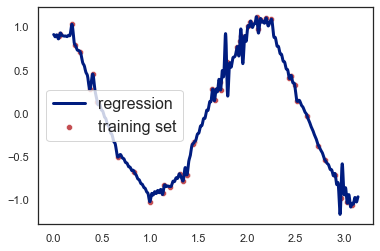

In [246]:
# fit the curve for plot (z)
m = 3  # Set the desired capacity here

# Extract features
decay_power = 0
X_features = [i**(-decay_power) * np.cos(i*X) for i in range(1, m+1)]
X_features = np.column_stack(X_features)
X_reg = [1 * i**(-0.5) * np.cos(i*X) for i in range(1, 200)]
X_reg = np.column_stack(X_reg)
X_features_reg = np.concatenate((X_features,X_reg),axis = 1)

# Fit linear regression model
model = LinearRegression()
model.fit(X_features_reg, y)

# Predict on the entire x-axis
x_plot_features_z = [i**(-decay_power) * np.cos(i*x_plot) for i in range(1, m+1)]
x_plot_features_z = np.column_stack(x_plot_features_z)
x_plot_reg = [1 * i**(-0.5) * np.cos(i*x_plot) for i in range(1, 200)]
x_plot_reg = np.column_stack(x_plot_reg)
x_plot_features_z = np.concatenate((x_plot_features_z,x_plot_reg),axis = 1)

y_pred_plot_z = model.predict(x_plot_features_z)


sns.lineplot(x=x_plot,y=y_pred_plot_z, label="regression")
sns.scatterplot(x=X, y=y, label = "training set", color = 'r')
plt.legend()
plt.show()

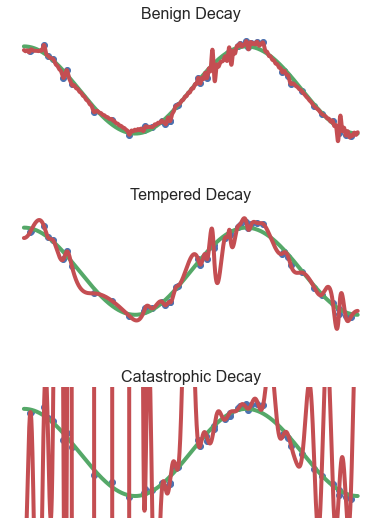

In [300]:
# Create a 1x3 grid of subplots with shared x and y axes
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize = (6,8))

# Plot data in each subplot
axs[0].scatter(X, y, color='b', label='samples')
axs[0].plot(x_plot, np.cos(3 * x_plot), color='g', label='target Function')
axs[0].plot(x_plot, y_pred_plot_z, color='r', label='Learned Function')

axs[1].scatter(X, y, color='b', label='samples')
axs[1].plot(x_plot, np.cos(3 * x_plot), color='g', label='target Function')
axs[1].plot(x_plot, y_pred_plot_e, color='r', label='Learned Function')

axs[2].scatter(X, y, color='b', label='samples')
axs[2].plot(x_plot, np.cos(3 * x_plot), color='g', label='target Function')
axs[2].plot(x_plot, y_pred_plot_g, color='r', label='Learned Function')

# Set the title for each subplot (optional)
axs[0].set_title('Benign Decay')
axs[1].set_title('Tempered Decay')
axs[2].set_title('Catastrophic Decay')

# turn off axes
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

# Set y limit
plt.ylim(-1.5,1.5)

# Adjust the layout to prevent overlapping of titles
plt.tight_layout()
plt.savefig('overfitting.pdf')  # Save the plot

# Display the plots
plt.show()



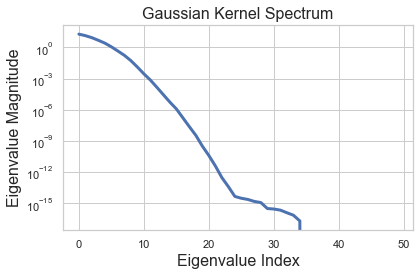

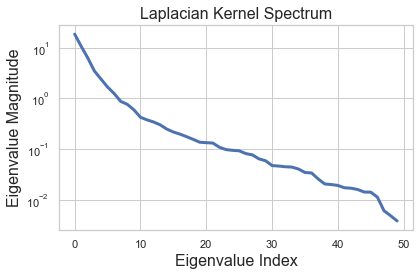

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


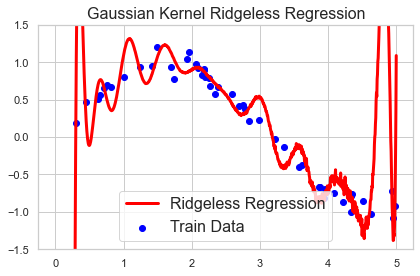

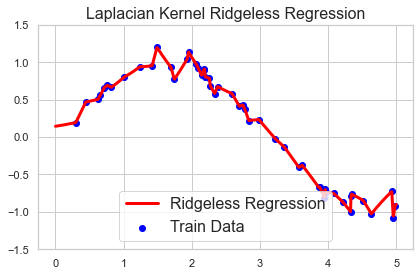

In [345]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from scipy.linalg import eigh
from sklearn.metrics.pairwise import pairwise_kernels

# Function to generate a dataset with noisy labels
def generate_dataset(n_samples=50, noise=0.1):
    X = np.sort(5 * np.random.rand(n_samples, 1), axis=0)
    y = np.sin(X).ravel() + noise * np.random.normal(size=n_samples)
    return X, y

# Function to compute and plot the spectrum of the kernel matrix
def plot_kernel_spectrum(X, kernel, title):
    K = pairwise_kernels(X, metric=kernel)
    eigenvalues, _ = eigh(K)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]

    plt.plot(sorted_eigenvalues, label=kernel.capitalize() + ' Spectrum', linewidth = 3)
    plt.title(title, fontsize = 16)
    plt.xlabel('Eigenvalue Index', fontsize = 16)
    plt.ylabel('Eigenvalue Magnitude', fontsize = 16)
    plt.yscale("log")
    #plt.legend()
    # Adjust the layout to prevent overlapping of titles
    plt.tight_layout()
    plt.savefig(kernel.capitalize() + 'kernel_spectrum.pdf')  # Save the plot
    plt.show()

# Function to perform kernel ridge regression and plot the results
def plot_kernel_ridge_regression(X_train, y_train, kernel, alpha, title):
    X_test = np.linspace(0, 5, 1000)[:, None]
    K_train = pairwise_kernels(X_train, X_train, metric=kernel)
    K_test = pairwise_kernels(X_test, X_train, metric=kernel)

    model = KernelRidge(alpha=alpha, kernel=kernel)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    plt.scatter(X_train, y_train, label='Train Data', color='blue')
    plt.plot(X_test, y_pred, label='Ridgeless Regression', color='red', linewidth = 3)
    plt.title(title, fontsize = 16)
    #plt.xlabel('X')
    #plt.ylabel('y')
    plt.ylim(-1.5,1.5)
    plt.legend(loc = 'lower center', fontsize = 16)
    plt.tight_layout()
    plt.savefig(kernel.capitalize() + 'kernel_overfitting.pdf')  # Save the plot
    plt.show()

# Generate a dataset
X_train, y_train = generate_dataset()

# Plot the spectrum for Gaussian Kernel
plot_kernel_spectrum(X_train, kernel='rbf', title='Gaussian Kernel Spectrum')

# Plot the spectrum for Laplacian Kernel
plot_kernel_spectrum(X_train, kernel='laplacian', title='Laplacian Kernel Spectrum')

# Perform Kernel Ridge Regression for Gaussian Kernel
plot_kernel_ridge_regression(X_train, y_train, kernel='rbf', alpha=0.0, title='Gaussian Kernel Ridgeless Regression')

# Perform Kernel Ridge Regression for Laplacian Kernel
plot_kernel_ridge_regression(X_train, y_train, kernel='laplacian', alpha=0.0, title='Laplacian Kernel Ridgeless Regression')
